# Anomalies in meal prices

In the Chamber of Deputies' CEAP, there is a list of 1,000's of meal expenses made by congresspeople. The law says that the congressperson cannot pay for any other, even being her advisor or SO. We want to work on this analysis to find possibly illegal and immoral expenses. They may have happened when the politician spent more than needed (e.g. the whole menu costs X but the bill was 2X) or too much in an specific period of time. In the end, we also want to alert about too expensive reibursements, even with an explanation behind of it.

Note: remember to correct prices with an inflation index (e.g. IPCA).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
from serenata_toolbox.datasets import fetch

fetch('2016-11-19-reimbursements.xz', '../data')
fetch('2016-09-03-companies.xz', '../data')
fetch('2016-11-29-yelp-companies.xz', '../data')
fetch('2016-12-02-foursquare-companies.xz', '../data')

In [3]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('../data/2016-11-19-reimbursements.xz',
                      dtype={'applicant_id': np.str,
                             'cnpj_cpf': np.str,
                             'congressperson_id': np.str,
                             'subquota_number': np.str},
                      low_memory=False)
dataset = dataset[dataset['congressperson_id'].notnull()]
dataset['issue_date'] = pd.to_datetime(dataset['issue_date'], errors='coerce')
dataset['issue_date_day'] = dataset['issue_date'].apply(lambda date: date.day)
dataset['issue_date_month'] = dataset['issue_date'].apply(lambda date: date.month)
dataset['issue_date_year'] = dataset['issue_date'].apply(lambda date: date.year)
dataset['issue_date_weekday'] = dataset['issue_date'].apply(lambda date: date.weekday())
dataset['issue_date_week'] = dataset['issue_date'].apply(lambda date: date.week)

The `companies.xz` dataset has businesses placed outside Brazilian area. We intentionally disconsider them.

In [4]:
is_in_brazil = '(-73.992222 < longitude < -34.7916667) & (-33.742222 < latitude < 5.2722222)'
companies = pd.read_csv('../data/2016-09-03-companies.xz',
                        dtype={'cnpj': np.str},
                        low_memory=False)
companies = companies.query(is_in_brazil)
companies['cnpj'] = companies['cnpj'].str.replace(r'\D', '')
dataset = pd.merge(dataset, companies,
                   how='left',
                   left_on='cnpj_cpf',
                   right_on='cnpj',
                   suffixes=('', '_company'))

In [5]:
dataset = \
    dataset.query('subquota_description == "Congressperson meal"')
companies = \
    companies[companies['cnpj'].isin(dataset.loc[dataset['cnpj'].notnull(),
                                                 'cnpj'])]

In [6]:
dataset['total_net_value'].describe()

count    190763.000000
mean         63.476994
std          75.954606
min           0.010000
25%          24.750000
50%          46.060000
75%          85.000000
max        5880.000000
Name: total_net_value, dtype: float64

In [7]:
dataset['total_net_value'].median()

46.06

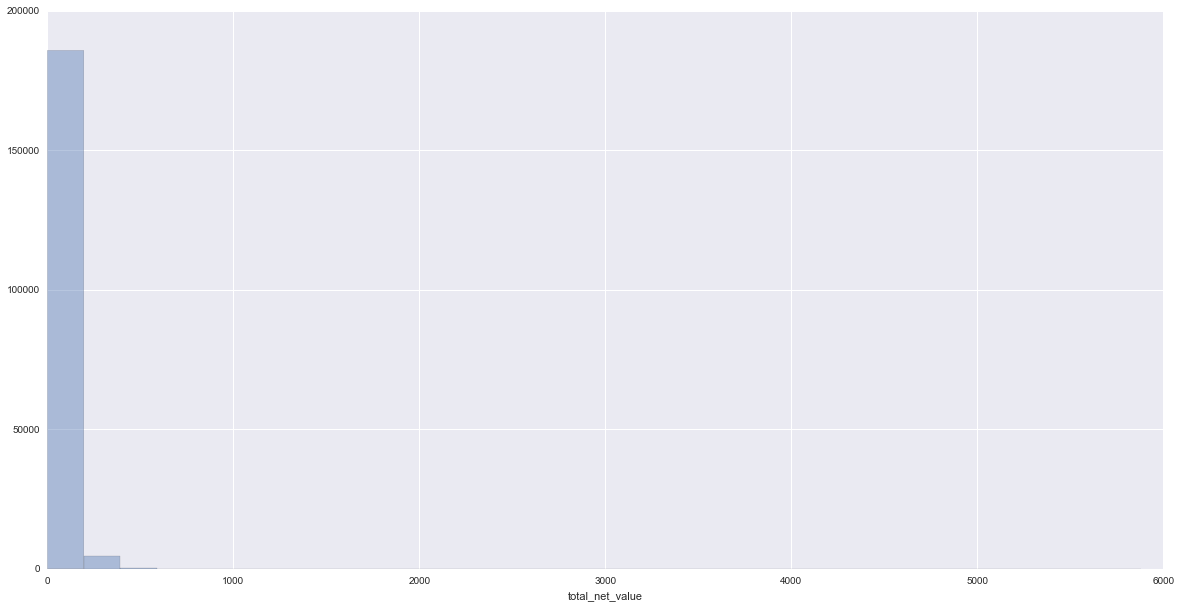

In [8]:
sns.distplot(dataset['total_net_value'],
             bins=30,
             kde=False)

In [9]:
bottom_99 = dataset['total_net_value'].quantile(0.99)
bottom_99

244.0

In [10]:
dataset[dataset['total_net_value'] < bottom_99].shape

(188854, 264)

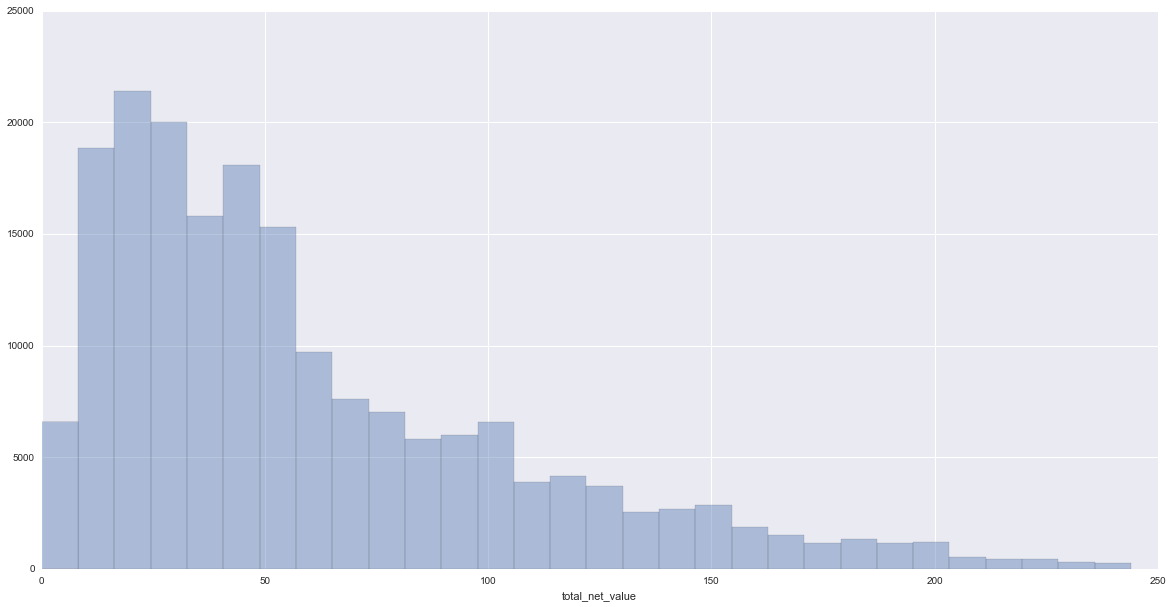

In [11]:
sns.distplot(dataset.loc[dataset['total_net_value'] < bottom_99, 'total_net_value'],
             bins=30,
             kde=False)

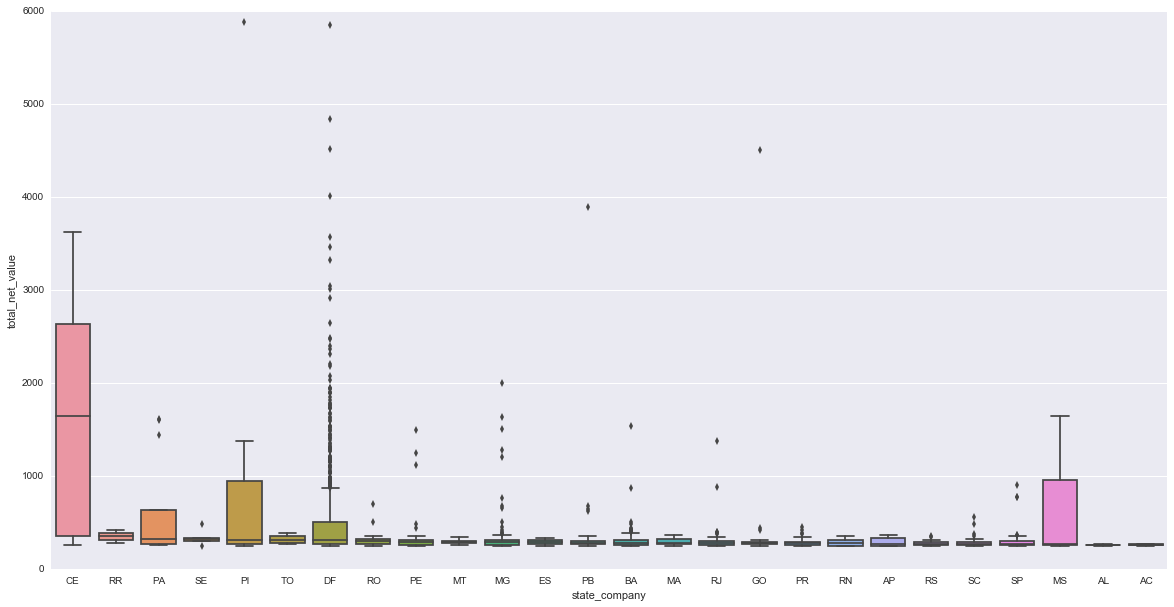

In [12]:
bottom_99_dataset = dataset.query('total_net_value > {}'.format(bottom_99))
ranking = bottom_99_dataset.groupby('state_company')['total_net_value'] \
    .median().sort_values(ascending=False)

sns.boxplot(x='state_company',
            y='total_net_value',
            data=bottom_99_dataset,
            order=ranking.index)

In [13]:
bottom_99_dataset.query('state_company == "CE"').shape

(13, 264)

In [14]:
dataset.query('state_company == "CE"').shape

(1433, 264)

In [15]:
bottom_99_dataset['state_company'].isnull().sum()

216

In [16]:
bottom_99_dataset.query('state_company == "CE"') \
    .sort_values('total_net_value', ascending=False)

,year,applicant_id,document_id,reimbursement_value_total,total_net_value,reimbursement_numbers,congressperson_name,congressperson_id,congressperson_document,term,...,secondary_activity_97_code,secondary_activity_98,secondary_activity_98_code,secondary_activity_99,secondary_activity_99_code,secondary_activity_9_code,latitude,longitude,latitude.1,longitude.1
23270,2009,1309,1636450,NaN,3623.84,3002,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
23291,2009,1309,1681391,NaN,2964.96,3082,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
606742,2012,1309,2427617,NaN,2865.30,4096,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
23284,2009,1309,1659987,NaN,2635.52,3046,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803441,2013,1309,5153384,NaN,1978.00,4330,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803430,2013,1309,5125345,NaN,1720.00,4298,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
23308,2009,1309,1710377,NaN,1647.20,3116,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803414,2013,1309,5080164,NaN,1634.00,4257,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
803429,2013,1309,5125329,NaN,1376.00,4298,MANOEL SALVIANO,74456,104.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245139,-39.308173,-7.245139,-39.308173
1401540,2016,1860,6070746,NaN,348.20,5519,JOSÉ AIRTON CIRILO,141464,101.0,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-7.245518,-39.322992,-7.245518,-39.322992


## Using Yelp to improve prices information

In [17]:
yelp = pd.read_csv('../data/2016-11-29-yelp-companies.xz',
                   low_memory=False)
yelp.head()

,categories,cnpj,coordinates.latitude,coordinates.longitude,distance,id,image_url,is_closed,location.address1,location.address2,...,location.state,location.zip_code,name,phone,price,rating,review_count,scraped_at,trade_name,url
0,"[{'alias': 'pizza', 'title': 'Pizza'}]",94.685.336/0011-50,-30.031437,-51.202667,3188.111070,pizza-hut-porto-alegre,https://s3-media1.fl.yelpcdn.com/bphoto/V5x_9v...,False,R. Castro Alves 791,NaN,...,RS,90430-131,Pizza Hut,5.551332e+11,$$,3.5,3.0,2016-11-28T21:31:50.631166,PIZZA HUT,https://www.yelp.com/biz/pizza-hut-porto-alegr...
1,"[{'alias': 'restaurants', 'title': 'Restaurant...",00.584.490/0001-10,-15.804710,-47.885071,1052.093553,severina-sabor-do-nordeste-brasília,https://s3-media1.fl.yelpcdn.com/bphoto/jJzTOh...,False,CLS 201 BL B lj 25,NaN,...,DF,70232-520,Severina Sabor do Nordeste,5.561322e+11,NaN,4.0,3.0,2016-11-28T21:31:56.262781,SEVERINA O SABOR DO NORDESTE,https://www.yelp.com/biz/severina-sabor-do-nor...
2,"[{'alias': 'restaurants', 'title': 'Restaurant...",01.587.436/0001-91,-15.758420,-47.888321,2948.572720,china-in-box-brasília-2,https://s3-media4.fl.yelpcdn.com/bphoto/PuAPol...,False,SQN 110 BL A lj 20 sl 103,NaN,...,DF,70753-010,China In Box,5.561334e+11,$$,3.5,6.0,2016-11-28T21:31:58.817795,CHINA IN BOX,https://www.yelp.com/biz/china-in-box-bras%C3%...
3,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",08.857.022/0001-84,-12.985820,-38.504559,226913.624760,boi-na-brasa-grill-churrascaria-e-pizzaria-sal...,https://s3-media1.fl.yelpcdn.com/bphoto/Qp7nsI...,False,Bairro Guarani - Liberdade,NaN,...,BA,40327-120,Boi na Brasa Grill - Churrascaria e Pizzaria,5.571326e+11,NaN,4.0,1.0,2016-11-28T21:32:05.065876,CHURRASCARIA BOI NA BRASA,https://www.yelp.com/biz/boi-na-brasa-grill-ch...
4,"[{'alias': 'pizza', 'title': 'Pizza'}]",00.941.379/0001-34,-22.824841,-43.049351,2.055793,rodo-grill-são-gonçalo,NaN,False,R. Doutor Feliciano Sodré 115,NaN,...,RJ,24440-440,Rodo Grill,5.521261e+11,NaN,5.0,1.0,2016-11-28T21:32:14.769193,RODO GRILL,https://www.yelp.com/biz/rodo-grill-s%C3%A3o-g...


We have data for just 8.6% of the companies which received from the "Congressperson meal" subquota.

In [18]:
yelp['price'].notnull().sum()

1563

In [19]:
companies.shape

(18013, 228)

In [20]:
yelp['price'].isnull().sum()

10651

In [21]:
yelp['price.int'] = yelp['price'].str.len()
states_with_records = \
    yelp[yelp['price'].notnull()].groupby('location.state')['location.state'].count() > 10
states_with_records = states_with_records[states_with_records].index

In [22]:
yelp_just_significant_states = \
    yelp[yelp['price'].notnull() &
         yelp['location.state'].isin(states_with_records)]
yelp_just_significant_states['location.state'].value_counts()

DF    410
SP    277
RJ    197
BA    158
PR    114
RS     93
PE     90
MG     57
CE     52
SC     32
PB     18
RN     13
GO     12
PA     12
Name: location.state, dtype: int64

Yelp won't be that useful for now, since we don't have a lot of data. Will leave it for another analysis.

## Predict prices

The idea here is to try to predict the "right range for prices" in a specific place. If we can have a good accuracy, everything far from the prediction could be considered an outlier.

In [23]:
bottom_99_dataset.iloc[0, :57]

year                                                          2009
applicant_id                                                  1059
document_id                                                1647604
reimbursement_value_total                                      NaN
total_net_value                                               1100
reimbursement_numbers                                         3017
congressperson_name                                     JOÃO MATOS
congressperson_id                                            73873
congressperson_document                                        473
term                                                          2007
state                                                           SC
party                                                         PMDB
term_id                                                         53
subquota_number                                                 13
subquota_description                           Congressperson 

**DummyRegressor with mean strategy as a baseline**

In [24]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

X = bottom_99_dataset[['year']]
y = bottom_99_dataset['total_net_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = DummyRegressor(strategy='mean')
model.fit(X_train, y_train)
model.score(X_test, y_test)

-0.0070334011808164121

In [25]:
from sklearn.preprocessing import LabelEncoder

le_state = LabelEncoder()
le_city = LabelEncoder()
factor_columns = ['state_company', 'city']
model_dataset = bottom_99_dataset.dropna(subset=factor_columns)
model_dataset['state_company'] = le_state.fit_transform(model_dataset['state_company'])
model_dataset['city'] = le_city.fit_transform(model_dataset['city'])

model_columns = ['cnpj',
                 'issue_date_day',
                 'issue_date_month',
                 'issue_date_year']
X = model_dataset[model_columns + factor_columns]
y = model_dataset['total_net_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**LinearRegression**

Not very good accuracy.

In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.091001115821311762

What if we could improve it using the type of business as a feature? e.g. restaurant, hotel, grill...

In [27]:
import unicodedata

def normalize_string(string):
    if isinstance(string, str):
        nfkd_form = unicodedata.normalize('NFKD', string.lower())
        return nfkd_form.encode('ASCII', 'ignore').decode('utf-8')

In [28]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

stopwords = nltk.corpus.stopwords.words('portuguese')
count_vect = CountVectorizer(stop_words=stopwords)
trade_names = dataset.loc[dataset['supplier'].notnull(),
                          'supplier'].unique()
trade_names = np.vectorize(normalize_string)(trade_names)
dataset_counts = count_vect.fit_transform(trade_names)

In [29]:
frequent_words = sorted(list(zip(count_vect.get_feature_names(),
    np.asarray(dataset_counts.sum(axis=0)).ravel())), key=lambda x: -x[1])

In [30]:
frequent_words[:20]

[('ltda', 22097),
 ('restaurante', 10348),
 ('alimentos', 4469),
 ('comercio', 3537),
 ('bar', 2596),
 ('churrascaria', 2344),
 ('epp', 1830),
 ('lanchonete', 1642),
 ('pizzaria', 1170),
 ('cafe', 1034),
 ('senac', 882),
 ('cia', 837),
 ('comercial', 836),
 ('grill', 815),
 ('hotel', 795),
 ('lanches', 770),
 ('rest', 623),
 ('alimenticios', 522),
 ('posto', 514),
 ('aprendizagem', 500)]

In [31]:
frequent_words = dict(frequent_words)

excluded_keywords = ['ltda', 'cia', 'epp']
[frequent_words.pop(keyword) for keyword in excluded_keywords]

[22097, 837, 1830]

In [32]:
def business_type(name):
    fun = np.vectorize(lambda x: normalize_string(x))
    keywords = set(fun(name.split(' '))) - set(stopwords)
    key_freqs = list(map(lambda x: (x, frequent_words.get(x)), list(keywords)))
    key_freqs = [key_freq for key_freq in key_freqs if key_freq[1] is not None]
    if key_freqs:
        key_freq = max(key_freqs, key=lambda x: x[1])
        return key_freq[0]

dataset['supplier_keyword'] = dataset['supplier'].apply(business_type)
bottom_99_dataset['supplier_keyword'] = \
    bottom_99_dataset['supplier'].apply(business_type)

/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
le_state = LabelEncoder()
le_city = LabelEncoder()
le_supplier_keyword = LabelEncoder()
factor_columns = ['state_company', 'supplier_keyword']
model_dataset = bottom_99_dataset.dropna(subset=factor_columns)
model_dataset['state_company'] = le_state.fit_transform(model_dataset['state_company'])
model_dataset['city'] = le_city.fit_transform(model_dataset['city'])
model_dataset['supplier_keyword'] = le_city.fit_transform(model_dataset['supplier_keyword'])

model_columns = ['cnpj',
                 'issue_date_day',
                 'issue_date_month',
                 'issue_date_year']
X = model_dataset[model_columns + factor_columns]
y = model_dataset['total_net_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [34]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.092188258450077054

Still not good enough. In fact, there's a serious mistake when considering this linear regression method for outlier detection: not just we're assuming that prices follow a linear regression (IMHO still good assumption, though), but outliers should be removed before running the regression. In other words, to find outliers, we must first remove them, having the regression score as just a accuracy estimator. May still be an interesting approach but we want to engage with something simpler first, to get the easier and most anomalous results.

## Common CNPJs

Expenses in the same restaurant are expected to follow a normal distribution. Can we find outliers in companies with enough expenses to analyze?

In [35]:
from scipy.stats import normaltest

def normaltest_pvalue(values):
    if len(values) >= 20:
        return normaltest(values).pvalue
    else:
        return 1

net_values_by_cnpj = dataset.groupby('cnpj_cpf')['total_net_value'] \
    .agg([len, np.mean, np.std, normaltest_pvalue]) \
    .sort_values('len', ascending=False) \
    .reset_index()
net_values_by_cnpj['threshold'] = net_values_by_cnpj['mean'] + \
    3 * net_values_by_cnpj['std']
applicants_per_cnpj = dataset.groupby('cnpj_cpf')['applicant_id'] \
    .aggregate(lambda x: len(set(x))).reset_index() \
    .rename(columns={'applicant_id': 'congresspeople'})
net_values_by_cnpj = pd.merge(net_values_by_cnpj, applicants_per_cnpj)
net_values_by_cnpj.head()

,cnpj_cpf,len,mean,std,normaltest_pvalue,threshold,congresspeople
0,33469172001644,17715.0,43.734512,13.620130,0.000000e+00,84.594903,668
1,33469172000672,11475.0,21.640217,13.073236,0.000000e+00,60.859925,515
2,10580005000356,2257.0,21.195002,14.927525,0.000000e+00,65.977576,207
3,00984060000277,2191.0,19.033231,17.327541,0.000000e+00,71.015856,216
4,09054158000119,1900.0,99.738053,45.660780,8.057065e-59,236.720393,273


In [36]:
len(net_values_by_cnpj.query('normaltest_pvalue < .05')) / len(net_values_by_cnpj)

0.03186994487143374

In [37]:
data_with_threshold = pd.merge(dataset, net_values_by_cnpj, on='cnpj_cpf') \
    .sort_values('total_net_value', ascending=False)

In [38]:
data_with_threshold['main_activity'] = \
    data_with_threshold['main_activity'].apply(normalize_string)

Let's discard hotel reibursements. There's no method yet to discover for how long the congressperson stayed in the hotel, so we can expect a high standard deviation in their expenses. Even when detecting outliers, it's too hard to investigate manually given the same reason.

Here, we just consider CNPJs where we have more than 20 reimbursements, from at least 3 congresspeople.

In [39]:
is_hotel_reimbursement = data_with_threshold['main_activity'] \
    .str.contains('hoteis').astype(np.bool)
outliers = data_with_threshold[~is_hotel_reimbursement] \
    .query('(congresspeople > 3) & (len >= 20) & (total_net_value > threshold)')
print(len(outliers), outliers['total_net_value'].sum())

1378 222687.85


## Foursquare

Before totally discarding it, let's see how significant is the Foursquare dataset.

In [40]:
foursquare = pd.read_csv('../data/2016-12-02-foursquare-companies.xz',
                         low_memory=False)
foursquare.head()

,allowMenuUrlEdit,attributes.groups,beenHere.count,beenHere.lastCheckinExpiredAt,beenHere.marked,beenHere.unconfirmedCount,bestPhoto.createdAt,bestPhoto.hasSticker,bestPhoto.height,bestPhoto.id,...,tags,timeZone,tips.count,tips.groups,trade_name,url,venueChains,venuePage.id,venueRatingBlacklisted,verified
0,True,"[{'count': 1, 'items': [{'displayValue': '$', ...",0.0,0.0,False,0.0,1.331568e+09,NaN,720.0,4f5e1d2de4b024154482f75c,...,[],America/Sao_Paulo,11.0,"[{'count': 11, 'items': [{'lang': 'pt', 'canon...",BOB'S URUGUAI,http://www.bobs.com.br,[{'logo': {'prefix': 'https://irs3.4sqi.net/im...,NaN,NaN,True
1,True,"[{'count': 1, 'items': [{'displayValue': '$', ...",0.0,0.0,False,0.0,1.476654e+09,NaN,1920.0,5803f2ecd67c4ebf6a907d49,...,[],America/Sao_Paulo,1.0,"[{'count': 1, 'items': [{'lang': 'pt', 'canoni...",HAMBURGUERIA ROMANA,NaN,[],NaN,NaN,False
2,True,"[{'count': 1, 'items': [{'displayValue': '$', ...",0.0,0.0,False,0.0,NaN,NaN,NaN,NaN,...,[],America/Sao_Paulo,4.0,"[{'count': 4, 'items': [{'lang': 'pt', 'canoni...",PIZZA HUT,NaN,[{'logo': {'prefix': 'https://irs0.4sqi.net/im...,NaN,NaN,False
3,True,"[{'count': 1, 'items': [{'displayValue': '$', ...",0.0,0.0,False,0.0,1.363381e+09,NaN,720.0,51438bb4e4b0702d1a537f5e,...,[],America/Sao_Paulo,0.0,"[{'count': 0, 'items': [], 'name': 'All tips',...",LIFE CONVENIENCIA,NaN,[],NaN,NaN,False
4,True,"[{'count': 1, 'items': [{'displayValue': '$', ...",0.0,0.0,False,0.0,NaN,NaN,NaN,NaN,...,[],America/Sao_Paulo,1.0,"[{'count': 1, 'items': [{'lang': 'pt', 'canoni...",CAFE KALDI,NaN,[],NaN,NaN,False


In [41]:
foursquare.iloc[0]

allowMenuUrlEdit                                                              True
attributes.groups                [{'count': 1, 'items': [{'displayValue': '$', ...
beenHere.count                                                                   0
beenHere.lastCheckinExpiredAt                                                    0
beenHere.marked                                                              False
beenHere.unconfirmedCount                                                        0
bestPhoto.createdAt                                                    1.33157e+09
bestPhoto.hasSticker                                                           NaN
bestPhoto.height                                                               720
bestPhoto.id                                              4f5e1d2de4b024154482f75c
bestPhoto.prefix                                https://irs2.4sqi.net/img/general/
bestPhoto.source.name                                       Foursquare for Android
best

In [42]:
print(foursquare['price.tier'].notnull().sum(),
      foursquare['price.tier'].notnull().sum() / len(companies),
      foursquare.query('confirmed_match == True')['price.tier'].notnull().sum() / len(companies))

8321 0.461944151446 0.16560262033


### Clustering for find the best group for a new restaurant

In [43]:
companies.shape

(18013, 228)

In [44]:
# is_cnpj = (dataset['cnpj_cpf'].str.len() == 14) & \
#     dataset['cnpj_cpf'].notnull() & \
#     dataset['document_type'] != 2
# cnpjs = dataset.sort_values('issue_date') \
#     .loc[is_cnpj, ['cnpj_cpf', 'supplier']] \
#     .drop_duplicates('cnpj_cpf', keep='last')
# cnpjs.head()

In [45]:
is_cnpj = dataset['cnpj_cpf'].str.len() == 14
cnpj_list = dataset.loc[is_cnpj].groupby('cnpj')['total_net_value'] \
    .agg([np.mean, np.std]).reset_index()
cnpj_list.shape

(18013, 3)

In [46]:
cnpj_list.head()

,cnpj,mean,std
0,00001868000106,77.990000,NaN
1,00003176000105,9.660000,2.867903
2,00005406000167,24.860000,NaN
3,00006453000125,53.015000,6.470027
4,00009332000137,17.828571,8.170009


In [47]:
cnpj_list = pd.merge(cnpj_list,
                     dataset[['cnpj_cpf', 'supplier']].drop_duplicates('cnpj_cpf'),
                     how='left',
                     left_on='cnpj', right_on='cnpj_cpf')
del cnpj_list['cnpj_cpf']
cnpj_list.head()

,cnpj,mean,std,supplier
0,00001868000106,77.990000,NaN,PEIXE FRITO & CIA
1,00003176000105,9.660000,2.867903,PÃES E DOCES NOVA GERAÇÃO 2001 LTDA
2,00005406000167,24.860000,NaN,MUSSACREDI COM. DE PRODUTOS ALIMENTÍCIOS LTDA
3,00006453000125,53.015000,6.470027,RIPA NA BRASA
4,00009332000137,17.828571,8.170009,SORVETERIA E CONFEITARIA DOM BOSCO LTDA


In [48]:
counts = dataset.loc[is_cnpj].groupby('cnpj')['applicant_id'] \
    .agg({'congresspeople': (lambda x: len(np.unique(x))),
          'len': (lambda x: len(x))
         }).reset_index()

cnpj_list = pd.merge(cnpj_list, counts)

**Calculate threshold for companies using their own receipts**

In [49]:
threshold_for_cnpjs = cnpj_list.groupby('cnpj') \
    .apply(lambda x: x['mean'].mean() + 3 * x['std'].mean()).reset_index() \
    .rename(columns={0: 'threshold'})
threshold_for_cnpjs

cnpj_list = pd.merge(cnpj_list, threshold_for_cnpjs)
cnpj_list.head()

,cnpj,mean,std,supplier,congresspeople,len,threshold
0,00001868000106,77.990000,NaN,PEIXE FRITO & CIA,1,1,NaN
1,00003176000105,9.660000,2.867903,PÃES E DOCES NOVA GERAÇÃO 2001 LTDA,1,4,18.263709
2,00005406000167,24.860000,NaN,MUSSACREDI COM. DE PRODUTOS ALIMENTÍCIOS LTDA,1,1,NaN
3,00006453000125,53.015000,6.470027,RIPA NA BRASA,2,2,72.425081
4,00009332000137,17.828571,8.170009,SORVETERIA E CONFEITARIA DOM BOSCO LTDA,4,7,42.338599


In [50]:
HOTEL_REGEX = r'hote[l(eis)(ls)]'
is_hotel_reimbursement = (cnpj_list['supplier'].str.lower().str.contains(HOTEL_REGEX))

Mark companies as having or not significant data.

In [51]:
rows = (~is_hotel_reimbursement) & \
    (cnpj_list['congresspeople'] > 3) & \
    (cnpj_list['len'] > 20)
cnpj_list['has_significant_data'] = False
cnpj_list.loc[rows, 'has_significant_data'] = True

In [52]:
print(cnpj_list['has_significant_data'].sum(),
      cnpj_list['has_significant_data'].sum() / len(cnpj_list['has_significant_data']))

755 0.0419141730972


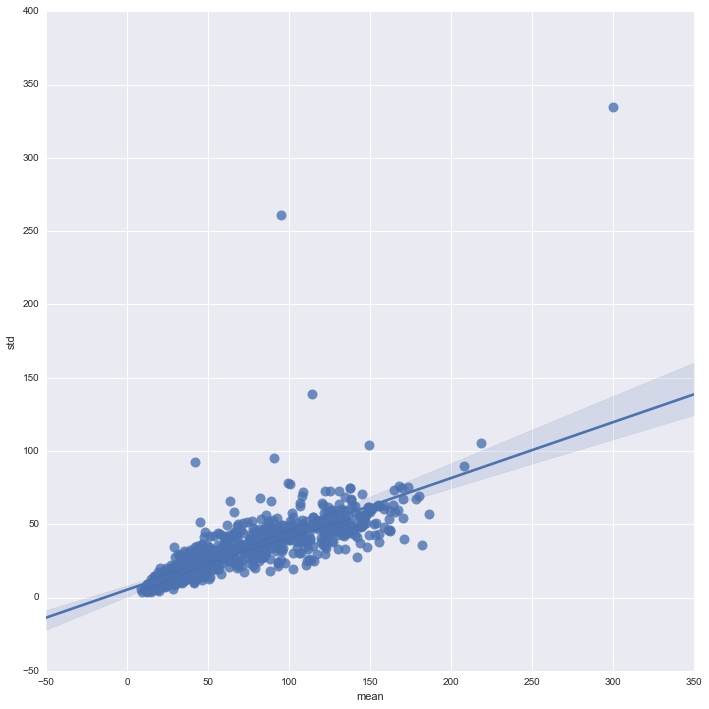

In [53]:
sns.lmplot('mean', 'std',
           data=cnpj_list.query('has_significant_data'),
           scatter_kws={'marker': 'D', 's': 100},
           size=10)

**Predict threshold classifying companies in clusters by their price ranges**

In [54]:
X = cnpj_list.loc[cnpj_list['has_significant_data'],
                  ['mean', 'std']]

In [55]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=0)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [56]:
cnpj_list.loc[cnpj_list['has_significant_data'], 'y'] = model.predict(X)

In [57]:
cnpj_list.query('y.notnull()').head()

,cnpj,mean,std,supplier,congresspeople,len,threshold,has_significant_data,y
34,00065927000100,57.913333,15.808737,VILLA RURAL COMPRAS LAZER LTDA.,19,96,105.339545,True,1.0
36,00068440000180,139.535882,45.859033,VOLMIR BORTONCELLO,11,51,277.112980,True,2.0
43,00073478000141,121.728966,57.327077,BIER FASS CERVEJARIA LTDA.,34,58,293.710196,True,2.0
70,00110791000102,76.221818,40.561074,IRMAOS MARINHO LTDA,34,55,197.905040,True,0.0
77,00120318000106,137.657368,48.572452,RESTAURANTE CABANA DO SOL,14,38,283.374725,True,2.0


In [58]:
rows = (~cnpj_list['has_significant_data']) & \
    cnpj_list['std'].notnull() & \
    (~is_hotel_reimbursement)
X = cnpj_list.loc[rows, ['mean', 'std']]
cnpj_list.loc[rows, 'y'] = model.predict(X)

In [59]:
threshold_for_groups = cnpj_list.groupby('y') \
    .apply(lambda x: x['mean'].mean() + 4 * x['std'].mean()).reset_index() \
    .rename(columns={0: 'threshold'})
threshold_for_groups

,y,threshold
0,0.0,218.901778
1,1.0,85.289990
2,2.0,376.493529


In [60]:
group_thresholds = pd.merge(cnpj_list.query('~has_significant_data'),
                            threshold_for_groups,
                            on='y',
                            suffixes=('', '_group'))

cnpj_list = pd.merge(cnpj_list,
                     group_thresholds[['cnpj', 'threshold_group']],
                     how='left')
cnpj_list.loc[~cnpj_list['has_significant_data'], 'threshold'] = \
    cnpj_list['threshold_group']

In [61]:
cnpj_list.query('(~has_significant_data) & std.notnull()').head()

,cnpj,mean,std,supplier,congresspeople,len,threshold,has_significant_data,y,threshold_group
1,00003176000105,9.660000,2.867903,PÃES E DOCES NOVA GERAÇÃO 2001 LTDA,1,4,85.289990,False,1.0,85.289990
3,00006453000125,53.015000,6.470027,RIPA NA BRASA,2,2,85.289990,False,1.0,85.289990
4,00009332000137,17.828571,8.170009,SORVETERIA E CONFEITARIA DOM BOSCO LTDA,4,7,85.289990,False,1.0,85.289990
5,00012093000174,163.460000,4.978032,MONTANA GRILL CHURRASCARIA,1,2,376.493529,False,2.0,376.493529
9,00015327000137,16.240000,0.729589,YELLOW - COMIDA CASEIRA E PIZZARIA LTDA. - ME,1,3,85.289990,False,1.0,85.289990


In [62]:
cnpj_list.query('has_significant_data').head()

,cnpj,mean,std,supplier,congresspeople,len,threshold,has_significant_data,y,threshold_group
34,00065927000100,57.913333,15.808737,VILLA RURAL COMPRAS LAZER LTDA.,19,96,105.339545,True,1.0,NaN
36,00068440000180,139.535882,45.859033,VOLMIR BORTONCELLO,11,51,277.112980,True,2.0,NaN
43,00073478000141,121.728966,57.327077,BIER FASS CERVEJARIA LTDA.,34,58,293.710196,True,2.0,NaN
70,00110791000102,76.221818,40.561074,IRMAOS MARINHO LTDA,34,55,197.905040,True,0.0,NaN
77,00120318000106,137.657368,48.572452,RESTAURANTE CABANA DO SOL,14,38,283.374725,True,2.0,NaN


In [63]:
cnpj_list.query('threshold.notnull()').sample(5, random_state=10)

,cnpj,mean,std,supplier,congresspeople,len,threshold,has_significant_data,y,threshold_group
6629,08275419000168,31.850000,9.828784,FIRENZE COMERCIO DE ALIMENTOS LTDA EPP,2,2,85.289990,False,1.0,85.289990
3745,04976832000107,59.467500,8.414319,CASA DA CODORNA,2,4,85.289990,False,1.0,85.289990
763,01156690000135,89.034783,8.655206,O CASARÃO,1,23,218.901778,False,0.0,218.901778
2069,02986561000137,165.429135,58.074328,CENTER GRILL RESTAURANTE LTDA,27,104,339.652118,True,2.0,NaN
1989,02905110011405,9.200000,7.769813,GR S/A,7,13,85.289990,False,1.0,85.289990


In [64]:
del cnpj_list['threshold_group']

In [65]:
merged = pd.merge(dataset, cnpj_list,
                  how='left',
                  left_on='cnpj_cpf',
                  right_on='cnpj',
                  suffixes=('', '_company'))

In [66]:
merged['supplier'] = merged['supplier'].astype(np.str)
is_hotel_reimbursement = \
    (merged['supplier'].str.lower().str.contains(HOTEL_REGEX))

merged[~is_hotel_reimbursement].query('total_net_value > threshold').shape

(2173, 274)

In [67]:
keys = ['year',
        'congressperson_name',
        'document_id',
        'total_net_value',
        'threshold',
        'cnpj_cpf',
        'has_significant_data',
        'name']

merged['diff'] = merged['threshold'] - merged['total_net_value']
merged[~(is_hotel_reimbursement | merged['has_significant_data'])] \
    .query('(total_net_value > threshold)') \
    .sort_values('diff', ascending=False).head(10)[keys]

,year,congressperson_name,document_id,total_net_value,threshold,cnpj_cpf,has_significant_data,name
94924,2013,DR. ADILSON SOARES,5300272,85.34,85.289990,02765401000168,False,PENSAO SABOR DO RINK LTDA - EPP
117943,2014,SANDRA ROSADO,5454230,85.35,85.289990,10859154000197,False,TAKAMI SUSHI HOUSE RESTAURANTE LTDA - ME
104929,2013,ARNALDO JORDY,5167672,85.39,85.289990,04100916000174,False,CRISTIANE R. SALOMAO - ME
183257,2016,JORGE SOLLA,6096707,85.45,85.289990,13561691000225,False,AUTO PECAS A NORMA LTDA - ME
89108,2013,LUIZ ALBERTO,5142306,376.70,376.493529,62413877003268,False,MELIA BRASIL ADMINISTRACAO HOTELEIRA E COMERCI...
130385,2014,EROS BIONDINI,5384615,85.50,85.289990,41914680000136,False,FRANCISCO CARLOS GONZAGA REIS - EPP
146624,2015,PASTOR EURICO,5594431,85.50,85.289990,41021361000100,False,MARILEIDE FERREIRA DA SILVA & CIA LTDA - ME
122083,2014,RAUL HENRY,5572619,85.50,85.289990,08902603000190,False,RESTAURANTE TA SAN YUEN LTDA
3383,2009,ONYX LORENZONI,1620485,85.50,85.289990,89248397000149,False,SEABRA & CIA LTDA - EPP
48394,2011,ROGÉRIO PENINHA MENDONÇA,2227453,85.50,85.289990,02438947000104,False,D'PAULLUS ALIMENTOS LTDA - ME


In [68]:
merged[~is_hotel_reimbursement].shape

(185887, 275)

In [69]:
merged[~is_hotel_reimbursement] \
    .query('(total_net_value > threshold)')['total_net_value'].shape

(2173,)

In [70]:
merged[~is_hotel_reimbursement] \
    .query('(total_net_value > threshold)')['total_net_value'].sum()

349683.91000000003

In [71]:
merged[~is_hotel_reimbursement] \
    .query('(total_net_value > threshold) & (has_significant_data == False)')['total_net_value'].shape

(870,)

## Conclusions

For companies with significant data (defined by us as a company which received money at least 20x, from at least 3 distinct congresspeople), we use mean + 3 * std to detect outliers. Does not return all the suspect cases, but all of them, after some sampling investigation, seem to be very suspect.

Since there's "significant data" just for 4% of the companies, we need a way for extrapolating the results for not so known ones. For doing so, we classify companies in 3 clusters using K-Means, considering mean and standard deviation of their prices as features. Once classified, we consider their threshold mean + 4 * stds of their clusters (one extra std compared to places where we have enough reimbursements to know better).

Reimbursements made for expenses in hotels are discarded from this classifier, since they usually contain much more than meals (and we don't know for how long the congressperson was hosted in the place, not yet trustable for legal reports).